Group the data by locations and times:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.path as mplPath
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import WeekDay
from datetime import datetime


In [17]:
train=pd.read_csv('/Users/LeiYu/Desktop/NYC Taxi/mergeby.csv')

In [6]:
traingroup=['Date','Dawn','MorningRush', 'Afternoon', 'NightRush', 'Midnight', 'JFK', 'LGA',
          'EWR', 'UPM', 'MIDM', 'DM', 'LI', 'BL', 'OTHERS']
train_gb=train.groupby(traingroup)
train=train_gb.Time.count()
train=train.reset_index()

Add dummy variable which indicate weather the day is a business day

In [26]:
calendar = USFederalHolidayCalendar()
holidays = calendar.holidays(start=train.Date.min(), end=train.Date.max())
weekends=['2016-02-06','2016-02-07','2016-02-13','2016-02-14','2016-02-15','2016-02-20','2016-02-21','2016-02-27','2016-02-28']
weekends = pd.to_datetime(np.array(weekends)).date
train['Weekends&holidays']=((train.Date==weekends[0])|(train.Date==weekends[1])
     |(train.Date==weekends[2])|(train.Date==weekends[3])
     |(train.Date==weekends[4])|(train.Date==weekends[5])
     |(train.Date==weekends[6])|(train.Date==weekends[7])
     |(train.Date==weekends[8]))*1

Add weather data:

In [27]:
weather=pd.read_csv('/Users/LeiYu/Desktop/NYC Taxi/weather.csv')

In [15]:
weather.Date=train.Date.unique()
train=pd.merge(train,weather,on='Date')
train=train.drop(train.columns[0],1)
train=train.drop('Date',1)

AttributeError: 'DataFrame' object has no attribute 'Date'

In [33]:
train.to_csv('/Users/LeiYu/Desktop/NYC Taxi/model1.csv')

# Next, we train the data:

In [34]:
from sklearn.model_selection import train_test_split
import math
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import FeatureUnion
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_squared_error, median_absolute_error

/Users/LeiYu/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/LeiYu/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [36]:
labels=train.Time
train = train.drop(['Time'], 1)
train=train.drop(train.columns[0],1)
#split the data
X_train, X_test, y_train, y_test = train_test_split(train, labels, test_size=0.2, random_state = 2)

In [42]:
def scoring(clf):
    scores = cross_val_score(clf, X_train, y_train, cv=15, n_jobs=1, scoring = 'neg_median_absolute_error')
    print (np.median(scores) * -1)

Random forest regression:

In [43]:
rfr = RandomForestRegressor(n_estimators = 55,
                            min_samples_leaf = 3,
                            random_state = 2)
scoring(rfr)

415.7675583


In [44]:
gbr = GradientBoostingRegressor(learning_rate = 0.12,
                                n_estimators = 150,
                                max_depth = 8,
                                min_samples_leaf = 1,
                                random_state = 2)
scoring(gbr)

393.775582392


In [45]:
dtr = DecisionTreeRegressor(min_samples_leaf = 3,
                            max_depth = 8,
                            random_state = 2)
scoring(dtr)

557.825396825


In [46]:
abr = AdaBoostRegressor(n_estimators = 100,
                        learning_rate = 0.1,
                        loss = 'linear',
                        random_state = 2)
scoring(abr)

1465.47605014


In [47]:
rfr = rfr.fit(X_train, y_train)
gbr = gbr.fit(X_train, y_train)

rfr_preds = rfr.predict(X_test)
gbr_preds = gbr.predict(X_test)
final_preds = rfr_preds*0.5 + gbr_preds*0.5
print ("Daily error of trips count:", median_absolute_error(y_test, final_preds))

('Daily error of trips count:', 383.5363249504353)


In [48]:
y_test.reset_index(drop=True,inplace=True)

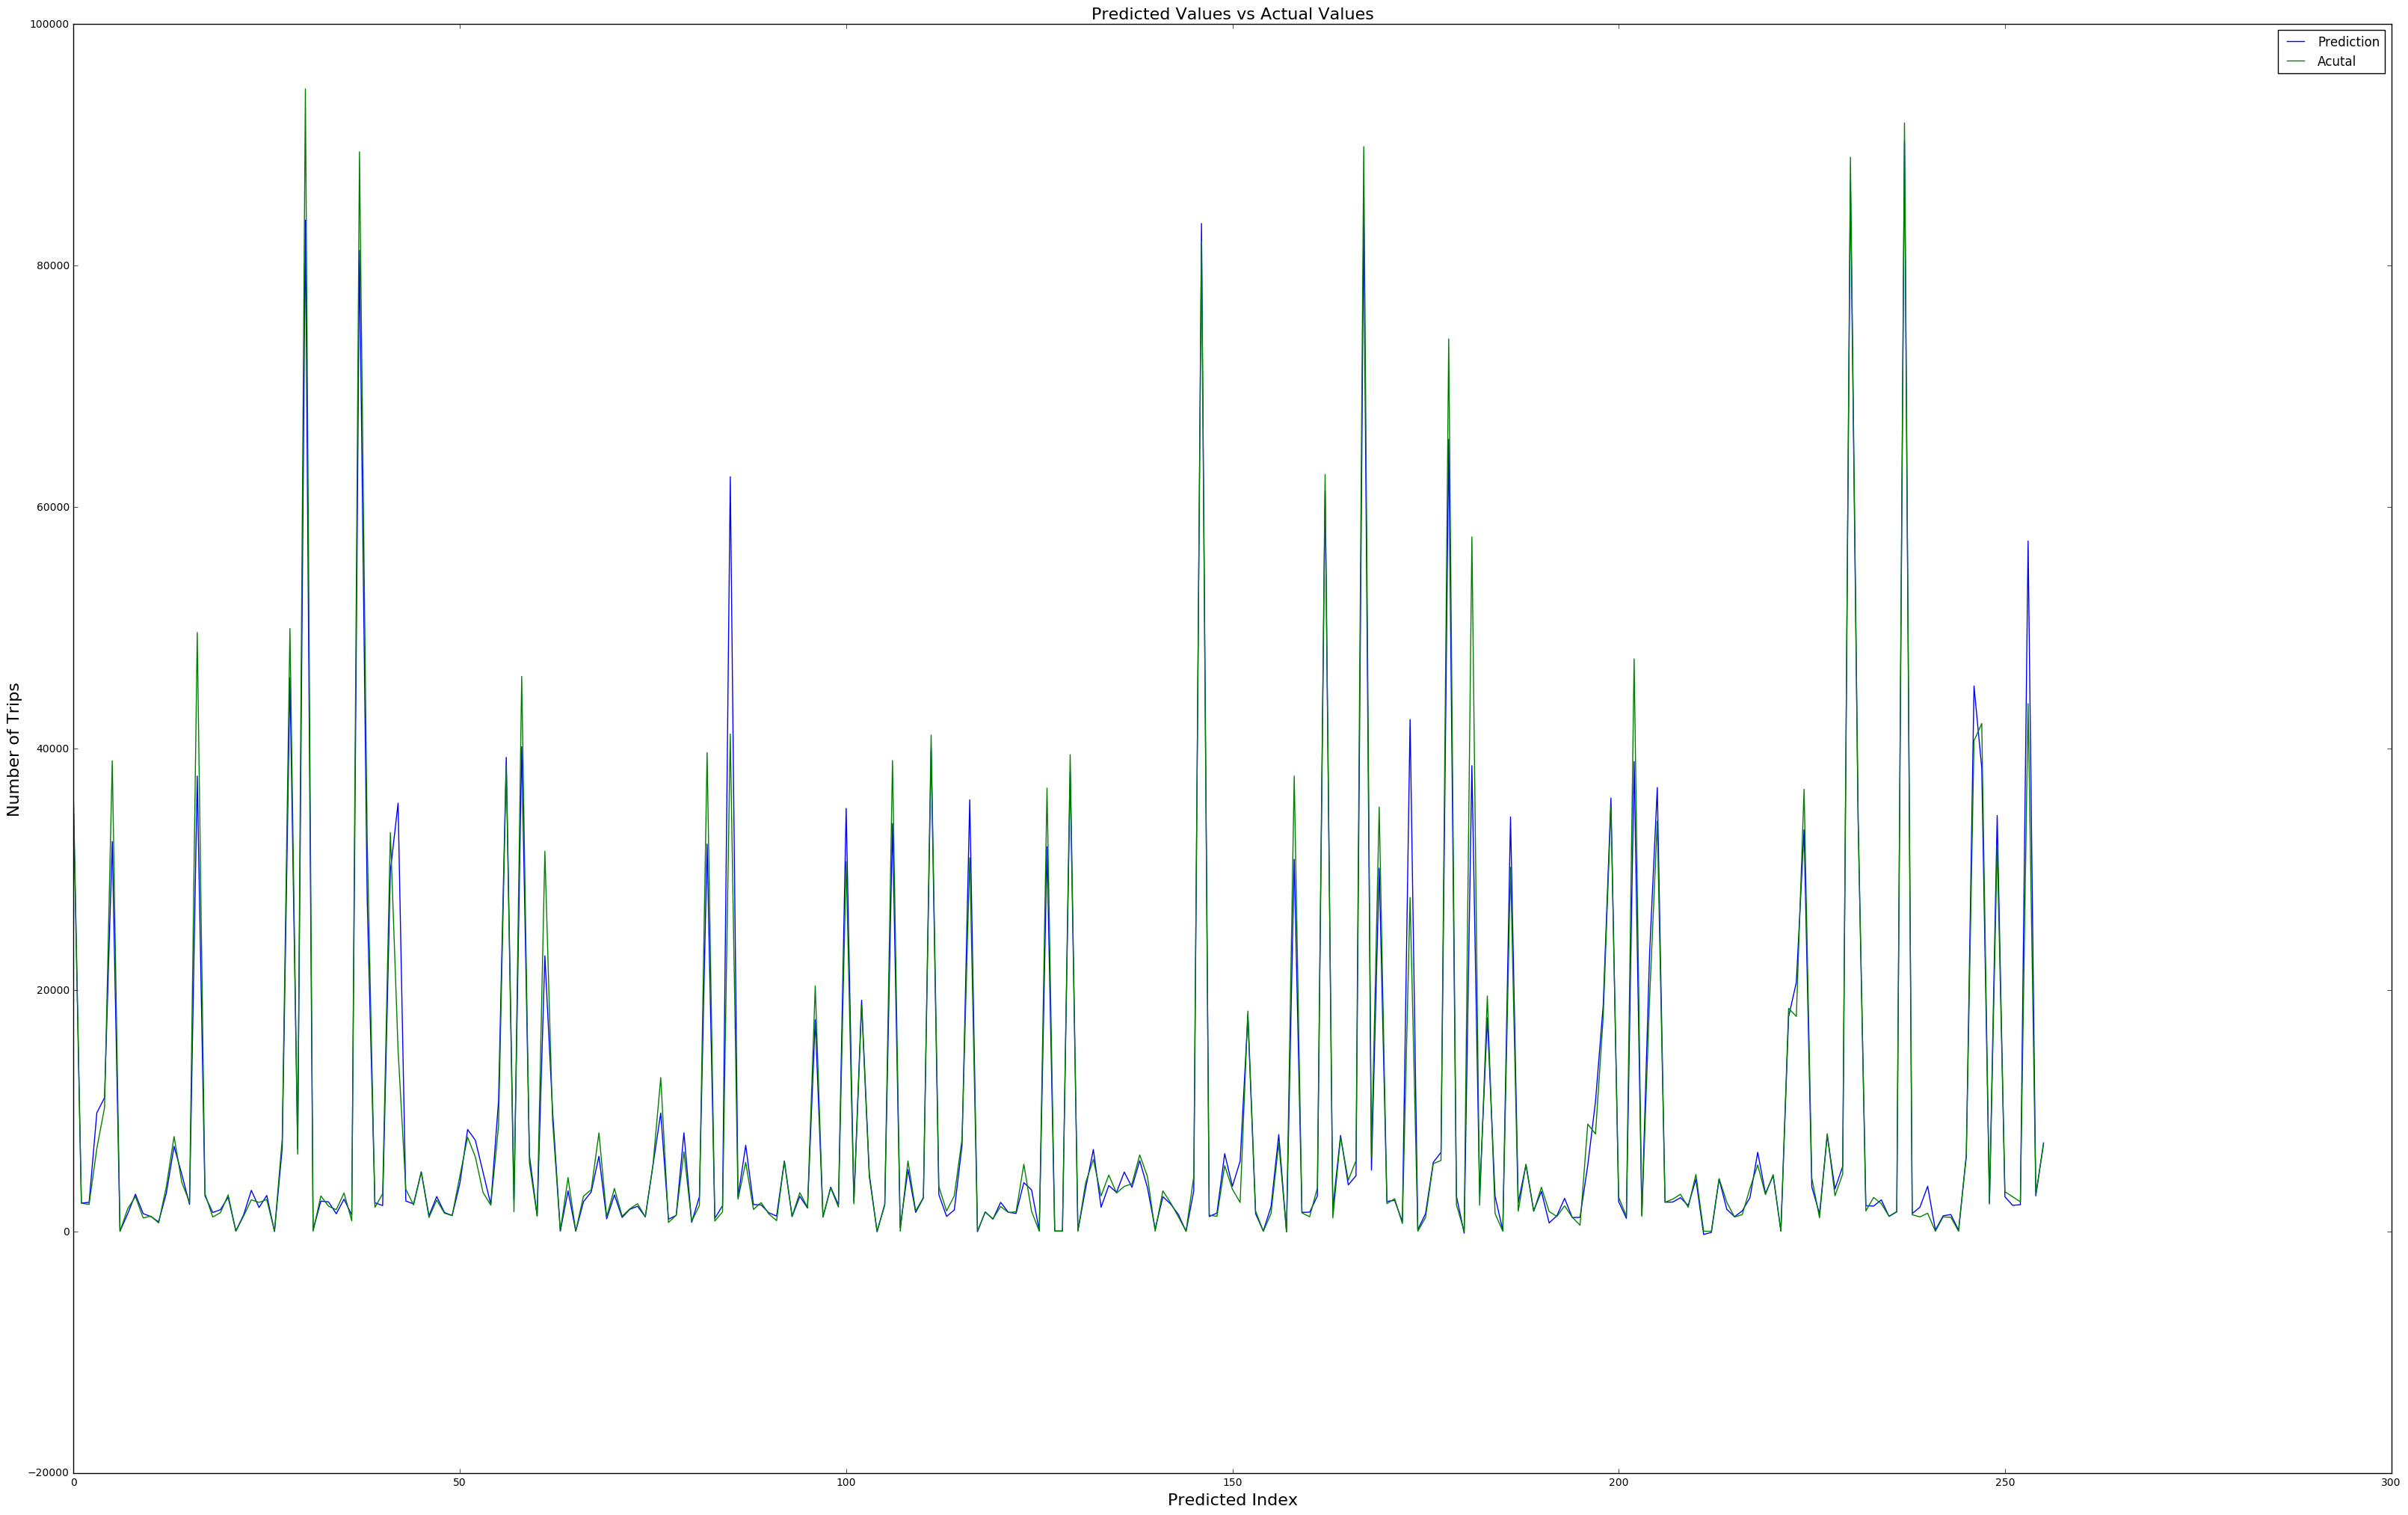

In [51]:
fs = 16
plt.figure(figsize=(40,25))
plt.plot(final_preds)
plt.plot(y_test)
plt.legend(['Prediction', 'Acutal'])
plt.ylabel("Number of Trips", fontsize = fs)
plt.xlabel("Predicted Index", fontsize = fs)
plt.title("Predicted Values vs Actual Values", fontsize = fs)
plt.show()

rank the feather by importance

In [53]:
def plot_importances(model, model_name):
    importances = model.feature_importances_
    std = np.std([model.feature_importances_ for feature in model.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]    

    # Plot the feature importances of the forest
    plt.figure(figsize = (8,5))
    plt.title("Feature importances of " + model_name)
    plt.bar(range(X_train.shape[1]), importances[indices], color="r", align="center")
    plt.xticks(range(X_train.shape[1]), indices)
    plt.xlim([-1, X_train.shape[1]])
    plt.show()

(0, 'MorningRush')
(1, 'Afternoon')
(2, 'NightRush')
(3, 'Midnight')
(4, 'JFK')
(5, 'LGA')
(6, 'EWR')
(7, 'UPM')
(8, 'MIDM')
(9, 'DM')
(10, 'LI')
(11, 'BL')
(12, 'OTHERS')
(13, 'Weekends&holidays')
(14, 'TEMP')
(15, 'Hunidity')
(16, 'Visibility')
(17, 'Wind')
(18, 'Rain')
(19, 'Snow')
(20, 'Nothing')


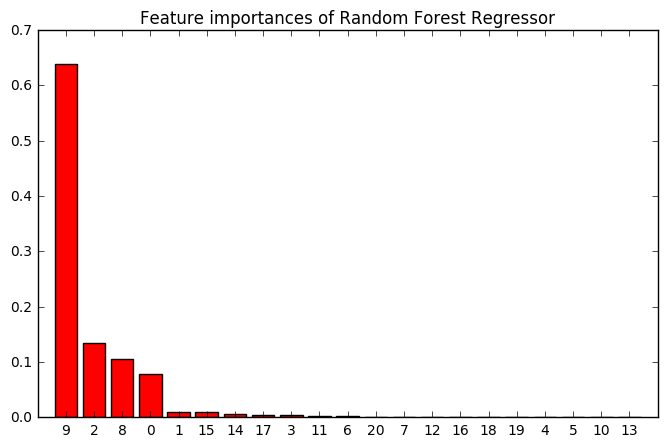

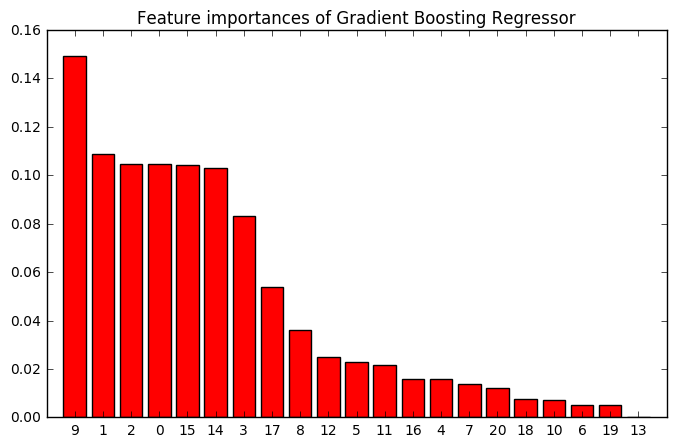

In [55]:
i = 0
for feature in X_train:
    print (i, feature)
    i += 1
    
plot_importances(rfr, "Random Forest Regressor")
plot_importances(gbr, "Gradient Boosting Regressor")